In [3]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from collections import Counter
import math
from torchview import draw_graph

Max Length is 29


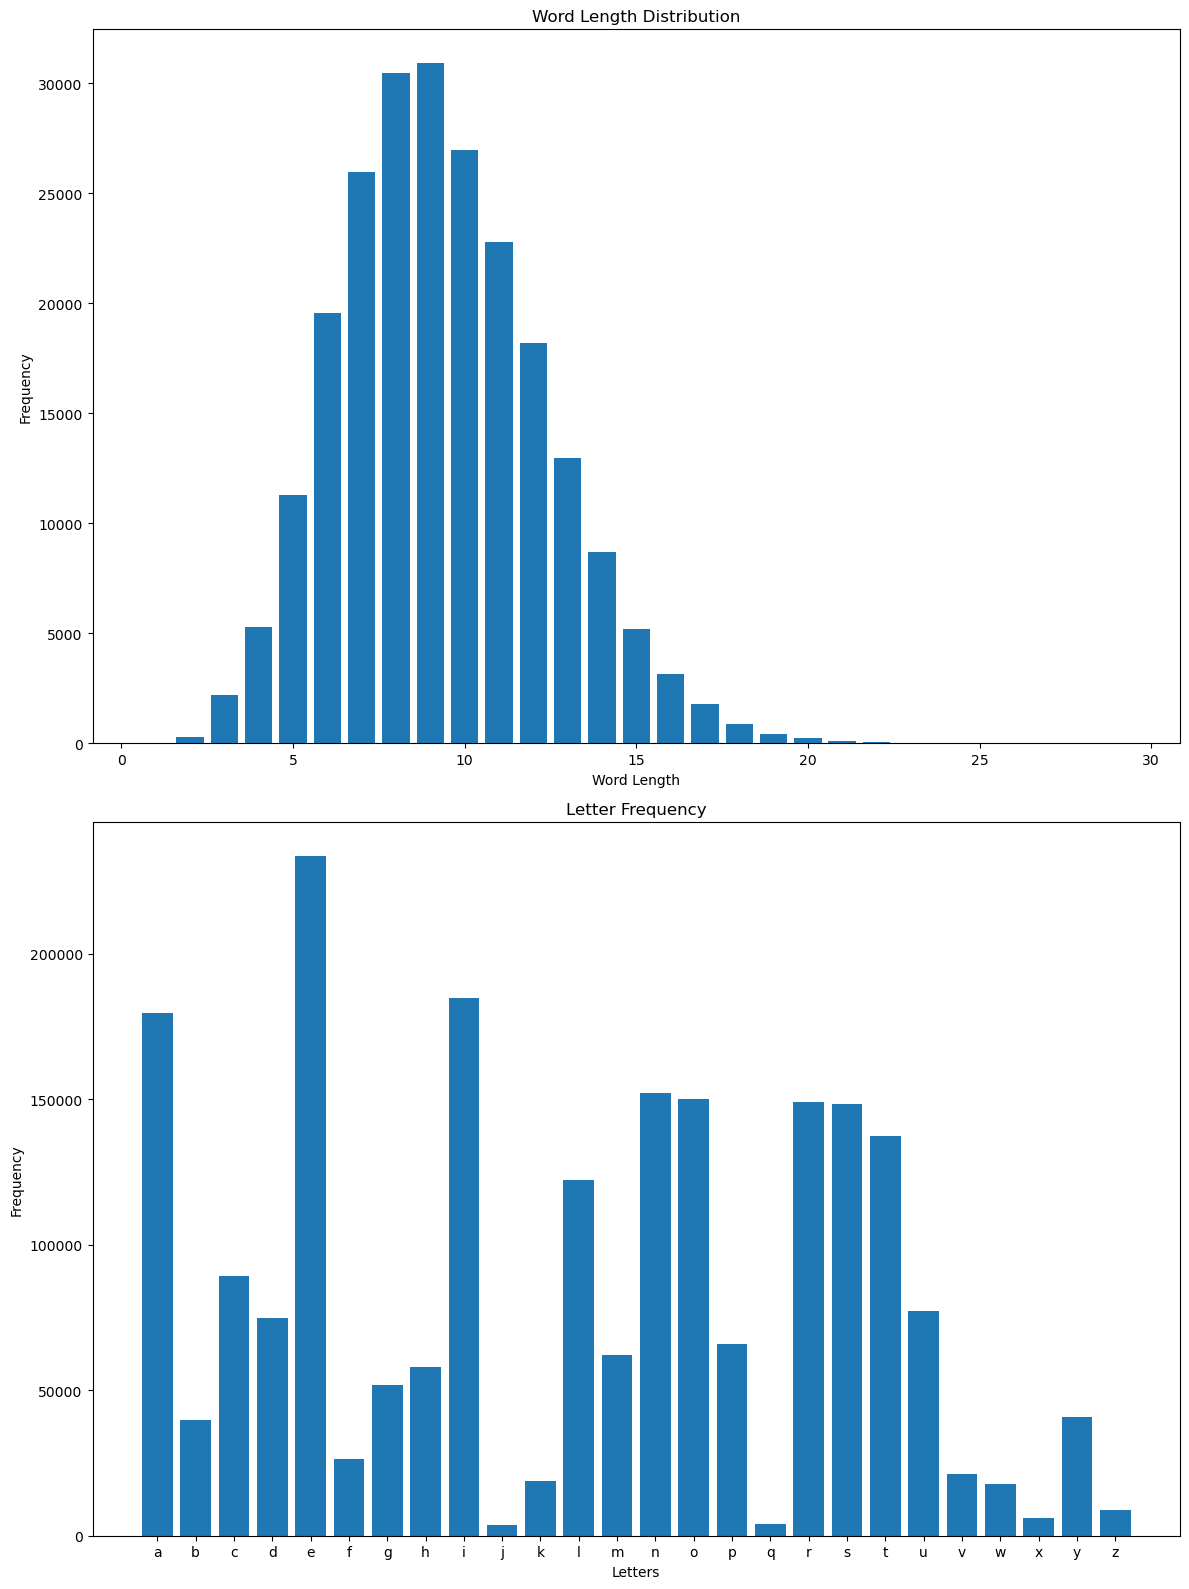

In [4]:
# Read the words from the file
with open('/Users/barryli/Desktop/TrexQuant/words_250000_train.txt', 'r') as file:
    words = file.read().split()

word_lengths = [len(word) for word in words]
length_counts = Counter(word_lengths)
print(f"Max Length is {max(word_lengths)}")
all_letters = ''.join(words)
letter_counts = Counter(all_letters)

# Plotting
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 16))

ax1.bar(length_counts.keys(), length_counts.values())
ax1.set_xlabel('Word Length')
ax1.set_ylabel('Frequency')
ax1.set_title('Word Length Distribution')

letters = sorted(letter_counts.keys())
frequencies = [letter_counts[letter] for letter in letters]
ax2.bar(letters, frequencies)
ax2.set_xlabel('Letters')
ax2.set_ylabel('Frequency')
ax2.set_title('Letter Frequency')

plt.tight_layout()
plt.show()

In [5]:
class HangmanEncoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim, num_heads, num_layers, max_length):
        super(HangmanEncoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.positional_encoding = self.create_sinusoidal_positional_encoding(max_length, embedding_dim)
        
        self.guessed_transform = nn.Linear(26, 62)  
        
        total_dim = embedding_dim + 62 + 6  
        encoder_layer = nn.TransformerEncoderLayer(d_model=total_dim, nhead=num_heads, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.final_fc = nn.Linear(64, 26)
        self.inter_fc = nn.Linear(total_dim, 64)
        #self.final_fc = nn.Linear(total_dim, 26)
        
    def create_sinusoidal_positional_encoding(self, max_length, embedding_dim):
        position = torch.arange(max_length).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, embedding_dim, 2) * (-math.log(10000.0) / embedding_dim))
        pe = torch.zeros(1, max_length, embedding_dim)
        pe[0, :, 0::2] = torch.sin(position * div_term)
        pe[0, :, 1::2] = torch.cos(position * div_term)
        return pe

    def forward(self, word_state, guessed_letters, remaining_trials):
        x = self.embedding(word_state)
        x = x + self.positional_encoding[:, :x.size(1), :].to(x.device)

        guessed_transformed = self.guessed_transform(guessed_letters.float())  
        guessed_expanded = guessed_transformed.unsqueeze(1).expand(-1, x.size(1), -1)

        remaining_trials_expanded = remaining_trials.unsqueeze(1).expand(-1, x.size(1), -1)

        combined = torch.cat((x, guessed_expanded, remaining_trials_expanded), dim=-1)
        
        encoder_output = self.transformer_encoder(combined)
        pooled = encoder_output.mean(dim=1)
        x = self.inter_fc(pooled)
        logits = self.final_fc(x)
        return logits

In [6]:
def encode_word_state(word, max_length, vocab_size=28):
    encoding = []
    for char in word:
        if char == '_':
            encoding.append(vocab_size - 2)  # '_' is second to last
        else:
            encoding.append(ord(char) - ord('a'))  # 'a' to 'z' are 0 to 25
    
    # Pad the encoding if necessary
    if len(encoding) < max_length:
        encoding += [vocab_size - 1] * (max_length - len(encoding))  # '[PAD]' is last
    
    return torch.tensor(encoding).unsqueeze(0)

In [7]:
def encode_remaining_guesses(remaining_guesses, max_guesses=6):
    encoding = [0] * max_guesses
    if remaining_guesses > 0:
        encoding[max_guesses - remaining_guesses] = 1
    return encoding

In [8]:
import random

class HangmanEnv:
    def __init__(self, word_list, max_guesses=6):
        self.word_list = word_list
        self.max_guesses = max_guesses
        self.reset()

    def reset(self,sample = True):
        if sample:
            self.word = random.choice(self.word_list)
        self.guessed_letters = set()
        self.current_state = ['_'] * len(self.word)
        self.remaining_guesses = self.max_guesses
        return self.get_state()

    def step(self, letter):
        if letter in self.guessed_letters:
            self.remaining_guesses -= 1 
        else:
            self.guessed_letters.add(letter)
            if letter in self.word:
                for i, char in enumerate(self.word):
                    if char == letter:
                        self.current_state[i] = letter
            else:
                self.remaining_guesses -= 1
        
        done = '_' not in self.current_state or self.remaining_guesses <= 0
        return self.get_state(), done

    def get_state(self):
        word_state = ''.join(self.current_state)
        guessed = [1 if chr(i + ord('a')) in self.guessed_letters else 0 for i in range(26)]
        return word_state, guessed , self.remaining_guesses

In [9]:
def encode_word_state(word, max_length, vocab_size=28):
    encoding = []
    for char in word:
        if char == '_':
            encoding.append(vocab_size - 2)  
        else:
            encoding.append(ord(char) - ord('a'))  
    
    # Pad the encoding if necessary
    if len(encoding) < max_length:
        encoding += [vocab_size - 1] * (max_length - len(encoding))  
    
    return torch.tensor(encoding).unsqueeze(0)

In [10]:
def collect_samples(model, env, num_games, device, max_length):
    samples = []
    wins = 0
    for _ in range(num_games):
        word_state, guessed, remaining_guesses = env.reset()
        done = False
        while not done:
            encoded_state = encode_word_state(word_state, max_length).to(device)
            guessed_tensor = torch.tensor(guessed).float().unsqueeze(0).to(device)
            remaining_guesses_encoded = encode_remaining_guesses(remaining_guesses)
            remaining_guesses_tensor = torch.tensor(remaining_guesses_encoded).float().unsqueeze(0).to(device)
            
            with torch.no_grad():
                action_probs = model(encoded_state, guessed_tensor, remaining_guesses_tensor).squeeze()
            action = torch.argmax(action_probs).item()
            letter = chr(action + ord('a'))
            next_state, done = env.step(letter)
            samples.append((word_state, guessed, remaining_guesses, env.word))
            word_state, guessed, remaining_guesses = next_state
            if done:
                if '_' not in word_state:
                    wins += 1
    accuracy = wins / num_games * 100
    return samples, accuracy

In [11]:
def train(model, env, optimizer, criterion, num_episodes, games_per_episode, device, max_length):
    model.to(device)
    for episode in range(num_episodes):
        model.eval()
        samples,win_rate = collect_samples(model, env, games_per_episode, device, max_length)
        model.train()
        print(f"Samples Collected")
        word_states, guessed_states,remaining_guesses, full_words = zip(*samples)
        encoded_states = torch.cat([encode_word_state(state, max_length) for state in word_states]).to(device)
        guessed_tensor = torch.tensor(guessed_states).float().to(device)
        remaining_guesses_encoded = [encode_remaining_guesses(guesses) for guesses in remaining_guesses]
        remaining_guesses_tensor = torch.tensor(remaining_guesses_encoded).float().to(device)
        
        targets = torch.zeros(len(full_words), 26).to(device)
        for i, (word, guessed) in enumerate(zip(full_words, guessed_states)):
            word_letters = set(word) - set('_')
            guessed_letters = set(chr(ord('a') + j) for j in range(26) if guessed[j] == 1)
            unguessed_letters = word_letters - guessed_letters
            if unguessed_letters:
                prob = 1.0 / len(unguessed_letters)
                for char in unguessed_letters:
                    targets[i, ord(char) - ord('a')] = 1
        outputs = model(encoded_states, guessed_tensor,remaining_guesses_tensor)
        loss = criterion(outputs, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        print(f"Episode {episode + 1}, Loss: {loss.item():.4f}, Win Rate: {win_rate:.4f}")

In [12]:
from tqdm import tqdm
def test_model(model, env, device, max_length):
    model.eval()  
    correct_guesses = 0
    total_words = len(env.word_list)
    count = 0
    for word in tqdm(env.word_list, desc="Testing words"):
        count +=1
        env.word = word  
        word_state, guessed = env.reset(sample=False)
        done = False

        while not done:
            #print(word_state)
            encoded_state = encode_word_state(word_state, max_length).to(device)
            guessed_tensor = torch.tensor(guessed).float().unsqueeze(0).to(device)
            
            with torch.no_grad():
                action_probs = model(encoded_state, guessed_tensor).squeeze()
            
            # Choose the highest probability letter that hasn't been guessed yet
            for action in torch.argsort(action_probs, descending=True):
                letter = chr(action.item() + ord('a'))
                if letter not in env.guessed_letters:
                    break

            t, done = env.step(letter)
            word_state,guessed = t

        if '_' not in word_state:
            correct_guesses += 1
        if count == 1000:
            break
    accuracy = correct_guesses / total_words
    return accuracy

In [13]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [14]:
env = HangmanEnv(words)

In [15]:
vocab_size = 28  # 26 letters + '_' for unknown + '[PAD]' for padding
embedding_dim = 100 
num_heads = 6
num_layers = 3
max_length = 30 

#model = HangmanEncoder(vocab_size, embedding_dim, num_heads, num_layers, max_length)
model = torch.load('/Users/barryli/Desktop/TrexQuant/models_added_fc/model_episode_8.pth',map_location=device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) #0.001
criterion = nn.BCEWithLogitsLoss()
#criterion = nn.CrossEntropyLoss()

In [ ]:
train(model, env, optimizer, criterion, num_episodes=3000, games_per_episode=300, device=device, max_length=max_length)

Samples Collected
Episode 1, Loss: 0.7120, Win Rate: 0.0000
Samples Collected
Episode 2, Loss: 0.6441, Win Rate: 0.0000
Samples Collected
Episode 3, Loss: 0.5799, Win Rate: 0.0000
Samples Collected
Episode 4, Loss: 0.5676, Win Rate: 0.0000
Samples Collected
Episode 5, Loss: 0.5532, Win Rate: 0.0000
Samples Collected
Episode 6, Loss: 0.5373, Win Rate: 0.0000
Samples Collected
Episode 7, Loss: 0.5405, Win Rate: 0.0000
Samples Collected
Episode 8, Loss: 0.5267, Win Rate: 0.0000
Samples Collected
Episode 9, Loss: 0.5275, Win Rate: 0.0000
Samples Collected
Episode 10, Loss: 0.5099, Win Rate: 0.0000
Samples Collected
Episode 11, Loss: 0.5073, Win Rate: 0.0000
Samples Collected
Episode 12, Loss: 0.5035, Win Rate: 0.0000
Samples Collected
Episode 13, Loss: 0.5026, Win Rate: 0.0000
Samples Collected
Episode 14, Loss: 0.5029, Win Rate: 0.0000
Samples Collected
Episode 15, Loss: 0.5073, Win Rate: 0.0000
Samples Collected
Episode 16, Loss: 0.5004, Win Rate: 0.0000
Samples Collected
Episode 17, Los

In [ ]:
import os
model_dir = '/root/models_added_fc'
os.makedirs(model_dir, exist_ok=True)

In [ ]:
torch.save(model, '/root/models_added_fc/org.pth')

In [ ]:
print(model)

HangmanEncoder(
  (embedding): Embedding(28, 100)
  (guessed_transform): Linear(in_features=26, out_features=62, bias=True)
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-2): 3 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=168, out_features=168, bias=True)
        )
        (linear1): Linear(in_features=168, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2048, out_features=168, bias=True)
        (norm1): LayerNorm((168,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((168,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (final_fc): Linear(in_features=64, out_features=26, bias=True)
  (inter_fc): Linear(in_features=168, out_features=64, bias=True)
)


In [ ]:
for i in range(0,3):
    print(f"Episode {(i+1) *500} Starting:")
    train(model, env, optimizer, criterion, num_episodes=500, games_per_episode=500, device=device, max_length=max_length)
    save_path = os.path.join(model_dir, f'model_episode_{i}.pth')
    torch.save(model, save_path)

In [ ]:
for i in range(3,7):
    print(f"Episode {(i+1) *500} Starting:")
    train(model, env, optimizer, criterion, num_episodes=500, games_per_episode=700, device=device, max_length=max_length)
    save_path = os.path.join(model_dir, f'model_episode_{i}.pth')
    torch.save(model, save_path)

Episode 2000 Starting:
Samples Collected
Episode 1, Loss: 0.2981, Win Rate: 54.1429
Samples Collected
Episode 2, Loss: 0.3053, Win Rate: 51.0000
Samples Collected
Episode 3, Loss: 0.3027, Win Rate: 51.7143
Samples Collected
Episode 4, Loss: 0.3005, Win Rate: 50.0000
Samples Collected
Episode 5, Loss: 0.3029, Win Rate: 52.0000
Samples Collected
Episode 6, Loss: 0.2996, Win Rate: 53.2857
Samples Collected
Episode 7, Loss: 0.3012, Win Rate: 49.7143
Samples Collected
Episode 8, Loss: 0.3051, Win Rate: 50.7143
Samples Collected
Episode 9, Loss: 0.3015, Win Rate: 50.8571
Samples Collected
Episode 10, Loss: 0.3021, Win Rate: 49.1429
Samples Collected
Episode 11, Loss: 0.3006, Win Rate: 54.4286
Samples Collected
Episode 12, Loss: 0.2977, Win Rate: 53.5714
Samples Collected
Episode 13, Loss: 0.3009, Win Rate: 54.0000
Samples Collected
Episode 14, Loss: 0.2991, Win Rate: 51.2857
Samples Collected
Episode 15, Loss: 0.2993, Win Rate: 50.0000
Samples Collected
Episode 16, Loss: 0.3010, Win Rate: 52

In [ ]:
for i in range(7,10):
    print(f"Episode {(i+1) *500} Starting:")
    train(model, env, optimizer, criterion, num_episodes=500, games_per_episode=900, device=device, max_length=max_length)
    save_path = os.path.join(model_dir, f'model_episode_{i}.pth')
    torch.save(model, save_path)

Episode 4000 Starting:
Samples Collected
Episode 1, Loss: 0.2954, Win Rate: 60.7778
Samples Collected
Episode 2, Loss: 0.3001, Win Rate: 60.1111
Samples Collected
Episode 3, Loss: 0.3041, Win Rate: 58.6667
Samples Collected
Episode 4, Loss: 0.2993, Win Rate: 56.7778
Samples Collected
Episode 5, Loss: 0.2990, Win Rate: 59.5556
Samples Collected
Episode 6, Loss: 0.2995, Win Rate: 55.5556
Samples Collected
Episode 7, Loss: 0.2979, Win Rate: 60.6667
Samples Collected
Episode 8, Loss: 0.2969, Win Rate: 58.8889
Samples Collected
Episode 9, Loss: 0.2965, Win Rate: 60.4444
Samples Collected
Episode 10, Loss: 0.2946, Win Rate: 60.2222
Samples Collected
Episode 11, Loss: 0.2989, Win Rate: 58.3333
Samples Collected
Episode 12, Loss: 0.2995, Win Rate: 61.1111
Samples Collected
Episode 13, Loss: 0.2924, Win Rate: 60.3333
Samples Collected
Episode 14, Loss: 0.2943, Win Rate: 59.3333
Samples Collected
Episode 15, Loss: 0.2944, Win Rate: 58.3333
Samples Collected
Episode 16, Loss: 0.2935, Win Rate: 63

In [ ]:
print(f"Total memory: {torch.cuda.get_device_properties(device).total_memory / 1e9:.2f} GB")
print(f"Allocated memory: {torch.cuda.memory_allocated(device) / 1e9:.2f} GB")
print(f"Reserved memory: {torch.cuda.memory_reserved(device) / 1e9:.2f} GB")
print(f"Free memory: {(torch.cuda.get_device_properties(device).total_memory - torch.cuda.memory_reserved(device)) / 1e9:.2f} GB")

Total memory: 25.39 GB
Allocated memory: 0.01 GB
Reserved memory: 0.02 GB
Free memory: 25.37 GB


In [ ]:
import gc
for obj in gc.get_objects():
    try:
        if torch.is_tensor(obj) and obj.is_cuda:
            print(type(obj), obj.size())
            del obj
    except Exception as e:
        pass

gc.collect()
torch.cuda.empty_cache()

<class 'torch.nn.parameter.Parameter'> torch.Size([64])
<class 'torch.nn.parameter.Parameter'> torch.Size([64, 168])
<class 'torch.nn.parameter.Parameter'> torch.Size([26])
<class 'torch.nn.parameter.Parameter'> torch.Size([26, 64])
<class 'torch.nn.parameter.Parameter'> torch.Size([168])
<class 'torch.nn.parameter.Parameter'> torch.Size([168])
<class 'torch.nn.parameter.Parameter'> torch.Size([168])
<class 'torch.nn.parameter.Parameter'> torch.Size([168])
<class 'torch.nn.parameter.Parameter'> torch.Size([168])
<class 'torch.nn.parameter.Parameter'> torch.Size([168, 2048])
<class 'torch.nn.parameter.Parameter'> torch.Size([2048])
<class 'torch.nn.parameter.Parameter'> torch.Size([2048, 168])
<class 'torch.nn.parameter.Parameter'> torch.Size([168])
<class 'torch.nn.parameter.Parameter'> torch.Size([168, 168])
<class 'torch.nn.parameter.Parameter'> torch.Size([504])
<class 'torch.nn.parameter.Parameter'> torch.Size([504, 168])
<class 'torch.nn.parameter.Parameter'> torch.Size([168])
<cl

In [ ]:

def sample_and_print_games(model, env, device, max_length, num_samples):
    model.eval()  
    correct_guesses = 0

    sampled_words = random.sample(env.word_list, num_samples)

    for word in tqdm(sampled_words, desc="Sampling games"):
        env.word = word  
        word_state, guessed,remaining_guesses = env.reset(sample=False)
        done = False
        
        print(f"\nTarget word: {word}")
        print(f"Initial state: {word_state}")

        while not done:
            encoded_state = encode_word_state(word_state, max_length).to(device)
            guessed_tensor = torch.tensor(guessed).float().unsqueeze(0).to(device)
            remaining_guesses_encoded = encode_remaining_guesses(remaining_guesses)
            remaining_guesses_tensor = torch.tensor(remaining_guesses_encoded).float().unsqueeze(0).to(device)
            
            with torch.no_grad():
                action_probs = model(encoded_state, guessed_tensor,remaining_guesses_tensor).squeeze()
            
            # Choose the highest probability letter that hasn't been guessed yet
            for action in torch.argsort(action_probs, descending=True):
                letter = chr(action.item() + ord('a'))
                if letter not in env.guessed_letters:
                    break

            t, done = env.step(letter)
            word_state,guessed,remaining_guesses = t
            
            print(f"Guessed '{letter}'. New state: {word_state}. Remaining guesses: {env.remaining_guesses}")

        if '_' not in word_state:
            correct_guesses += 1
            print("Word guessed correctly!")
        else:
            print("Failed to guess the word.")

    accuracy = correct_guesses / num_samples
    print(f"\nSample Accuracy: {accuracy:.2%}")
    return accuracy

In [ ]:
import sys
original_stdout = sys.stdout

# Redirect stdout to a file
with open('/root/output.txt', 'w') as f:
    sys.stdout = f
    num_samples = 5000
    sample_accuracy = sample_and_print_games(model, env, device, max_length, num_samples)

sys.stdout = original_stdout

Sampling games: 100%|██████████| 5000/5000 [00:52<00:00, 95.48it/s] 


In [ ]:
torch.save(model, '/root/fifth_trial.pth')